In [31]:
# Imports and Initial Setup
import numpy as np
import librosa
import librosa.display
import sounddevice as sd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [32]:
# Imports and Initial Setup
# import numpy as np # For numerical operations and array handling
# import librosa # For audio processing and feature extraction
# import librosa.display # For displaying audio visualizations
# import sounddevice as sd # For recording audio from microphone
# import matplotlib.pyplot as plt # For creating plots and visualizations
# from datetime import datetime 
# import os # For file and directory operations
# import pandas as pd # For creating data reports
# from tqdm import tqdm # For progress bars
# %matplotlib inline

# VoiceBatchProcessor Class Initialization
class VoiceBatchProcessor:
    def __init__(self, 
                 num_recordings=10, # Default number of recordings
                 duration=3, # Default duration in seconds
                 fs=44100, # Sample rate (44.1kHz)
                 output_dir='voice_recordings'):
        """
        Initialize batch processor for multiple voice recordings.
        
        Args:
            num_recordings: Number of recordings to capture
            duration: Duration of each recording in seconds
            fs: Sample rate
            output_dir: Directory to save recordings and results
        """
        self.num_recordings = num_recordings
        self.duration = duration
        self.fs = fs
        self.output_dir = output_dir
        self.recordings = [] # Store raw recordings
        self.features = [] # Store processed features
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

    # Audio Capture Function
    def capture_batch(self, pause_duration=2):
        """Record multiple audio samples with pauses between them."""
        print(f"Starting batch recording session for {self.num_recordings} samples")
        
        for i in range(self.num_recordings):
            print(f"\nRecording {i+1}/{self.num_recordings}")
            print(f"Starting in {pause_duration} seconds...")
            
             # Wait before starting new recording
            sd.sleep(int(pause_duration * 1000))
            
            # Record audio
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), 
                         samplerate=self.fs, 
                         channels=1) # Mono channel recording
            sd.wait() # Wait until recording is complete
            print("Recording finished")
            
            # Store recording metadata and audio
            self.recordings.append({
                'id': i+1,
                'timestamp': datetime.now(),
                'audio': audio.flatten(), # Convert to 1D array
                'raw_duration': len(audio) / self.fs
            })
            
            # Save raw audio to file
            filename = os.path.join(self.output_dir, f'recording_{i+1}_raw.npy')
            np.save(filename, audio.flatten())

    # Audio Preprocessing Function
    def preprocess_audio(self, audio):
        """Preprocess a single audio sample."""
        # Normalization - Scale audio to range [-1, 1]
        audio = audio / np.max(np.abs(audio))
        
        # Remove silence from start/end
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
        
        # Pre-emphasis - Boost high frequencies
        processed_audio = librosa.effects.preemphasis(trimmed_audio)
        
        return processed_audio

    # Feature Extraction Function
    def extract_features(self, audio):
        """Extract features from a single audio sample."""

        # Extract MFCCs (Mel-frequency cepstral coefficients)
        # MFCCs represent the short-term power spectrum of sound
            # The Mel scale is designed to mimic how the human ear perceives sound
            # Humans don't perceive frequencies linearly.
        mfccs = librosa.feature.mfcc(y=audio, sr=self.fs, n_mfcc=13)
        
        # Extract Mel spectrogram
        # Visual representation of sound frequencies over time
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.fs)
        
        return mfccs, mel_spec

    # Batch Processing Function
    def process_batch(self):
        """Process all recordings in the batch."""
        print("\nProcessing batch...")
        
        for i, rec in enumerate(tqdm(self.recordings)): # Progress bar
            # Preprocess audio
            processed_audio = self.preprocess_audio(rec['audio'])
            
            # Extract features
            mfccs, mel_spec = self.extract_features(processed_audio)
            
            # Store processed results
            self.features.append({
                'id': rec['id'],
                'processed_audio': processed_audio,
                'mfccs': mfccs,
                'mel_spec': mel_spec,
                'processed_duration': len(processed_audio) / self.fs
            })
            
            # Save processed audio and features
            base_path = os.path.join(self.output_dir, f'recording_{rec["id"]}')
            np.save(f'{base_path}_processed.npy', processed_audio)
            np.save(f'{base_path}_mfccs.npy', mfccs)
            np.save(f'{base_path}_melspec.npy', mel_spec)

    # Modified Visualization Function
def visualize_batch(self, plot_all=True):
    """
    Visualize results for all recordings in the batch.
    Args:
        plot_all: If True, plots all recordings. If False, plots only first 5
    """
    # Use all samples if plot_all=True, otherwise use 5
    display_count = len(self.features) if plot_all else min(len(self.features), 5)
    
    # Create a figure for waveforms
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All Processed Waveforms', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        plt.plot(self.features[i]['processed_audio'])
        plt.title(f'Recording {self.features[i]["id"]} Waveform')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Create a figure for mel spectrograms
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All Mel Spectrograms', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        img = librosa.display.specshow(
            librosa.power_to_db(self.features[i]['mel_spec'], ref=np.max),
            y_axis='mel', 
            x_axis='time'
        )
        plt.colorbar(img, format='%+2.0f dB')
        plt.title(f'Recording {self.features[i]["id"]} Mel Spectrogram')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Create a figure for MFCCs
    plt.figure(figsize=(15, 2*display_count))
    plt.suptitle('All MFCCs', fontsize=16)
    for i in range(display_count):
        plt.subplot(display_count, 1, i+1)
        img = librosa.display.specshow(
            self.features[i]['mfccs'], 
            x_axis='time'
        )
        plt.colorbar(img)
        plt.title(f'Recording {self.features[i]["id"]} MFCCs')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Report Generation Function
    def generate_report(self):
        """Generate summary report of the batch processing."""

        # Collect metadata for each recording
        report_data = []
        
        for rec, feat in zip(self.recordings, self.features):
            report_data.append({
                'Recording ID': rec['id'],
                'Timestamp': rec['timestamp'],
                'Raw Duration': rec['raw_duration'],
                'Processed Duration': feat['processed_duration'],
                'MFCC Shape': feat['mfccs'].shape,
                'Mel Spec Shape': feat['mel_spec'].shape
            })

        # Create and save report
        report_df = pd.DataFrame(report_data)
        report_df.to_csv(os.path.join(self.output_dir, 'batch_report.csv'), index=False)
        
        return report_df


# Usage example
def run_batch_processing():
    # Initialize processor
    processor = VoiceBatchProcessor(
        num_recordings=10,  
        duration=3,         
        fs=44100,          
        output_dir='voice_batch_results'
    )
    
    # Execute complete pipeline
    processor.capture_batch(pause_duration=2)
    processor.process_batch()
    
    # Visualize all results - Changed max_display to plot_all
    processor.visualize_batch(plot_all=True)  # This was the issue
    
    # Generate report
    report = processor.generate_report()
    print("\nBatch Processing Report:")
    print(report)
    
    return processor

In [33]:
class VoiceBatchProcessor:
    def __init__(self, num_recordings=10, duration=3, fs=44100, output_dir='voice_recordings'):
        self.num_recordings = num_recordings
        self.duration = duration
        self.fs = fs
        self.output_dir = output_dir
        self.recordings = []
        self.features = []
        os.makedirs(output_dir, exist_ok=True)
        
    def capture_batch(self, pause_duration=2):
        print(f"Starting batch recording session for {self.num_recordings} samples")
        
        for i in range(self.num_recordings):
            print(f"\nRecording {i+1}/{self.num_recordings}")
            print(f"Starting in {pause_duration} seconds...")
            sd.sleep(int(pause_duration * 1000))
            
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), samplerate=self.fs, channels=1)
            sd.wait()
            print("Recording finished")
            
            self.recordings.append({
                'id': i+1,
                'timestamp': datetime.now(),
                'audio': audio.flatten(),
                'raw_duration': len(audio) / self.fs
            })
            
            filename = os.path.join(self.output_dir, f'recording_{i+1}_raw.npy')
            np.save(filename, audio.flatten())
    
    def preprocess_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
        processed_audio = librosa.effects.preemphasis(trimmed_audio)
        return processed_audio
    
    def extract_features(self, audio):
        mfccs = librosa.feature.mfcc(y=audio, sr=self.fs, n_mfcc=13)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.fs)
        return mfccs, mel_spec
    
    def process_batch(self):
        print("\nProcessing batch...")
        for i, rec in enumerate(tqdm(self.recordings)):
            processed_audio = self.preprocess_audio(rec['audio'])
            mfccs, mel_spec = self.extract_features(processed_audio)
            
            self.features.append({
                'id': rec['id'],
                'processed_audio': processed_audio,
                'mfccs': mfccs,
                'mel_spec': mel_spec,
                'processed_duration': len(processed_audio) / self.fs
            })
            
            base_path = os.path.join(self.output_dir, f'recording_{rec["id"]}')
            np.save(f'{base_path}_processed.npy', processed_audio)
            np.save(f'{base_path}_mfccs.npy', mfccs)
            np.save(f'{base_path}_melspec.npy', mel_spec)

    def plot_batch(self):
        """Plot all recordings"""
        display_count = len(self.features)
        
        # Waveforms
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All Processed Waveforms', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            plt.plot(self.features[i]['processed_audio'])
            plt.title(f'Recording {self.features[i]["id"]} Waveform')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Mel spectrograms
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All Mel Spectrograms', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            img = librosa.display.specshow(
                librosa.power_to_db(self.features[i]['mel_spec'], ref=np.max),
                y_axis='mel', 
                x_axis='time'
            )
            plt.colorbar(img, format='%+2.0f dB')
            plt.title(f'Recording {self.features[i]["id"]} Mel Spectrogram')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # MFCCs
        plt.figure(figsize=(15, 2*display_count))
        plt.suptitle('All MFCCs', fontsize=16)
        for i in range(display_count):
            plt.subplot(display_count, 1, i+1)
            img = librosa.display.specshow(
                self.features[i]['mfccs'], 
                x_axis='time'
            )
            plt.colorbar(img)
            plt.title(f'Recording {self.features[i]["id"]} MFCCs')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    def generate_report(self):
        report_data = []
        for rec, feat in zip(self.recordings, self.features):
            report_data.append({
                'Recording ID': rec['id'],
                'Timestamp': rec['timestamp'],
                'Raw Duration': rec['raw_duration'],
                'Processed Duration': feat['processed_duration'],
                'MFCC Shape': feat['mfccs'].shape,
                'Mel Spec Shape': feat['mel_spec'].shape
            })
        
        report_df = pd.DataFrame(report_data)
        report_df.to_csv(os.path.join(self.output_dir, 'batch_report.csv'), index=False)
        return report_df

def run_batch_processing():
    # Initialize processor
    processor = VoiceBatchProcessor(
        num_recordings=10,  
        duration=3,         
        fs=44100,          
        output_dir='voice_batch_results'
    )
    
    # Execute pipeline
    processor.capture_batch(pause_duration=2)
    processor.process_batch()
    
    # Plot results
    processor.plot_batch()  # Changed from visualize_batch to plot_batch
    
    # Generate report
    report = processor.generate_report()
    print("\nBatch Processing Report:")
    print(report)
    
    return processor

Starting batch recording session for 10 samples

Recording 1/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 2/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 3/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 4/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 5/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 6/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 7/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 8/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 9/10
Starting in 2 seconds...
Recording...
Recording finished

Recording 10/10
Starting in 2 seconds...
Recording...
Recording finished

Processing batch...


100%|█| 10/10 [00:00<00:00, 73.


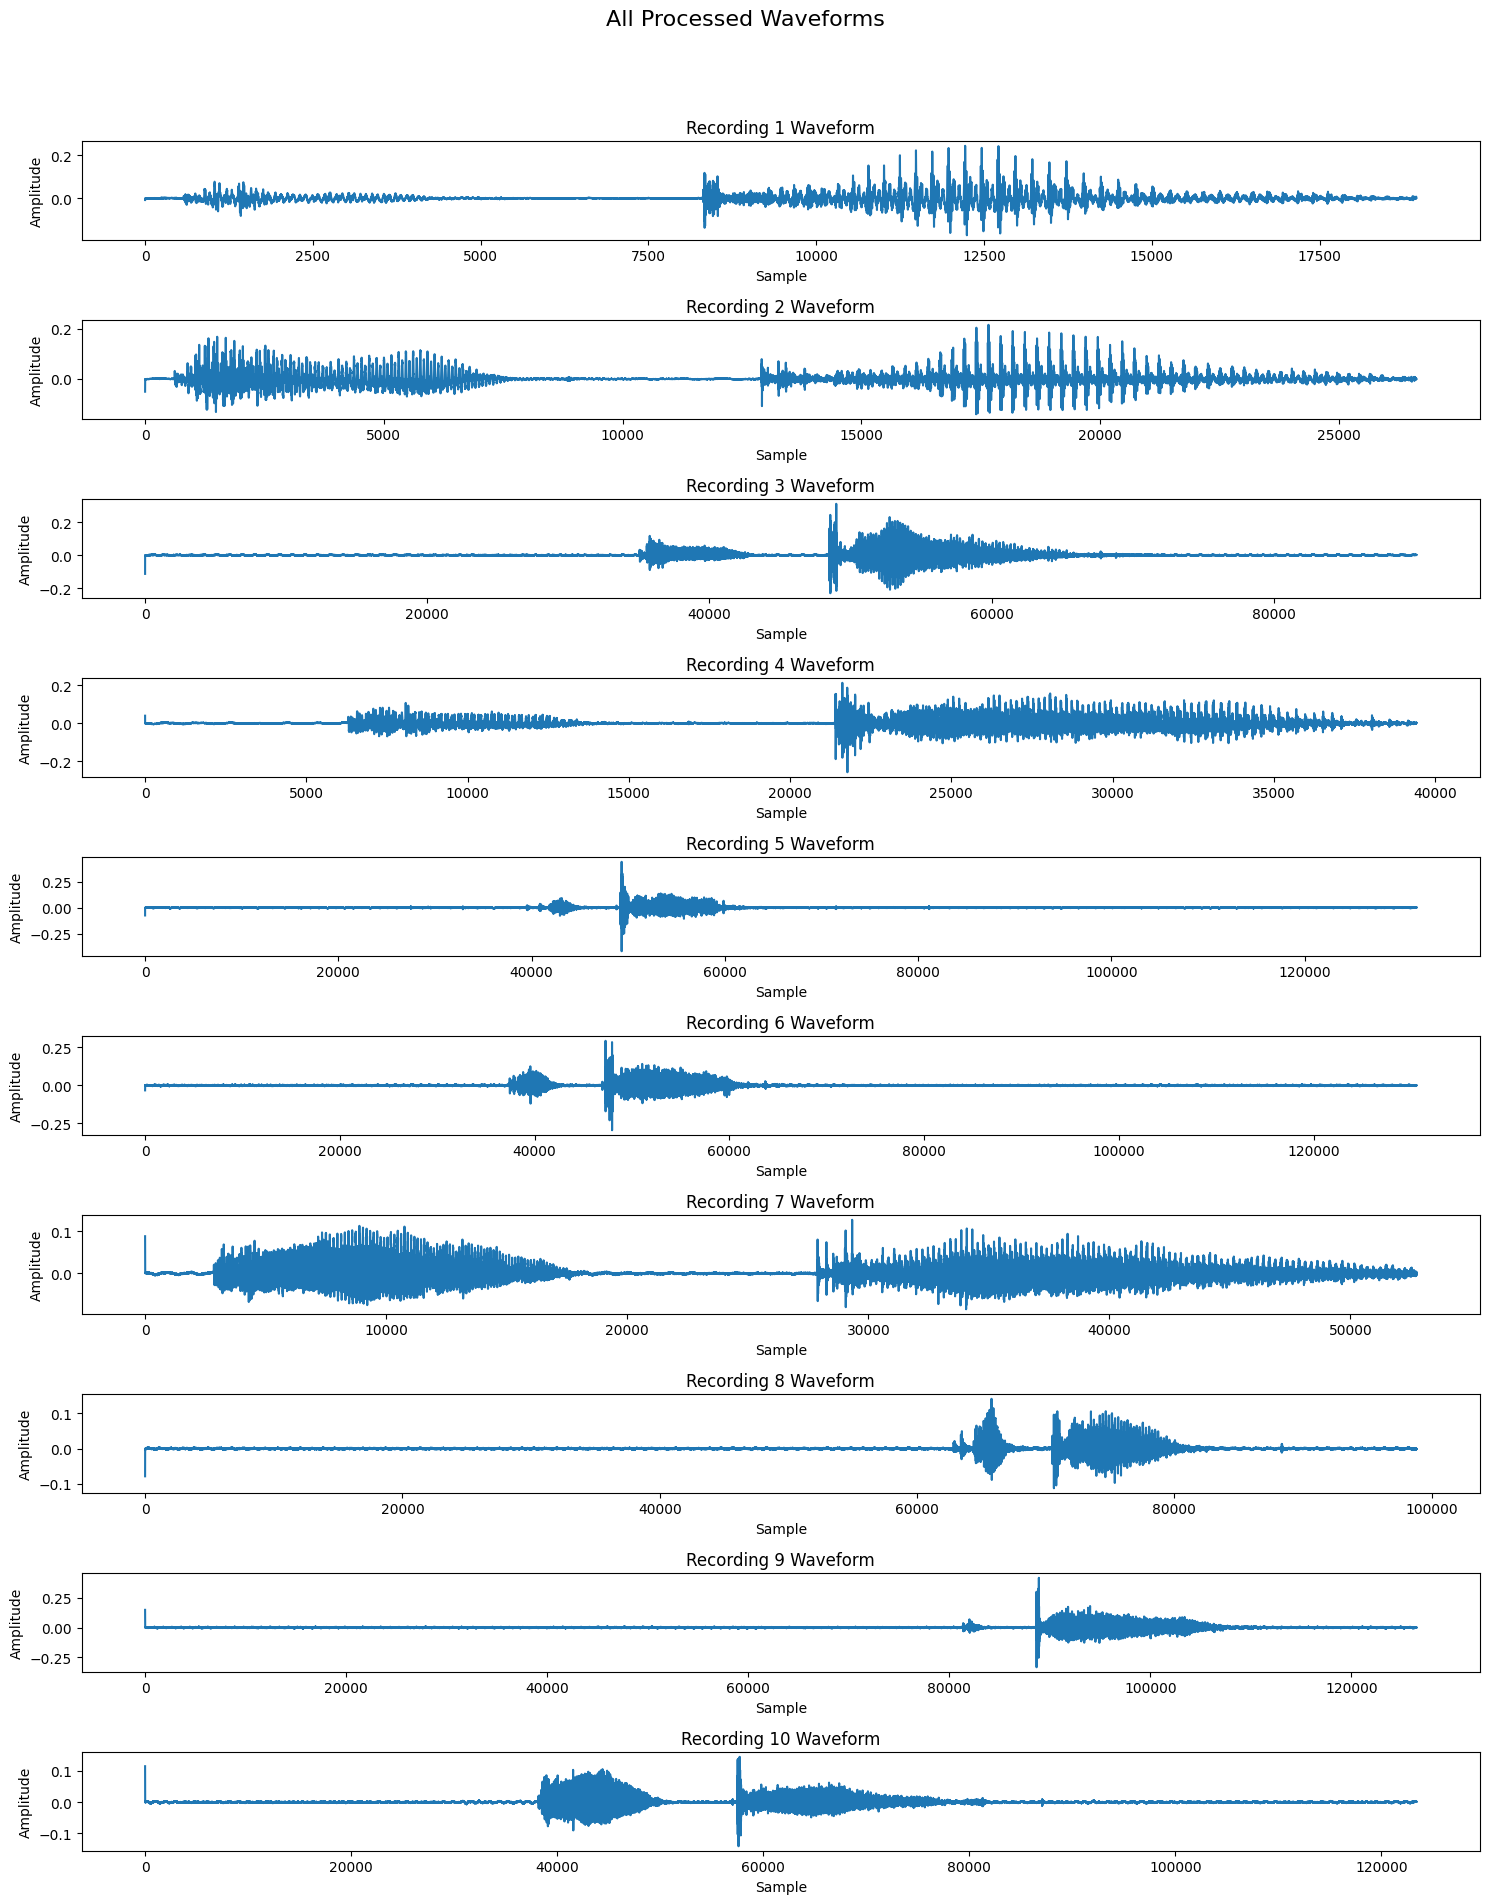

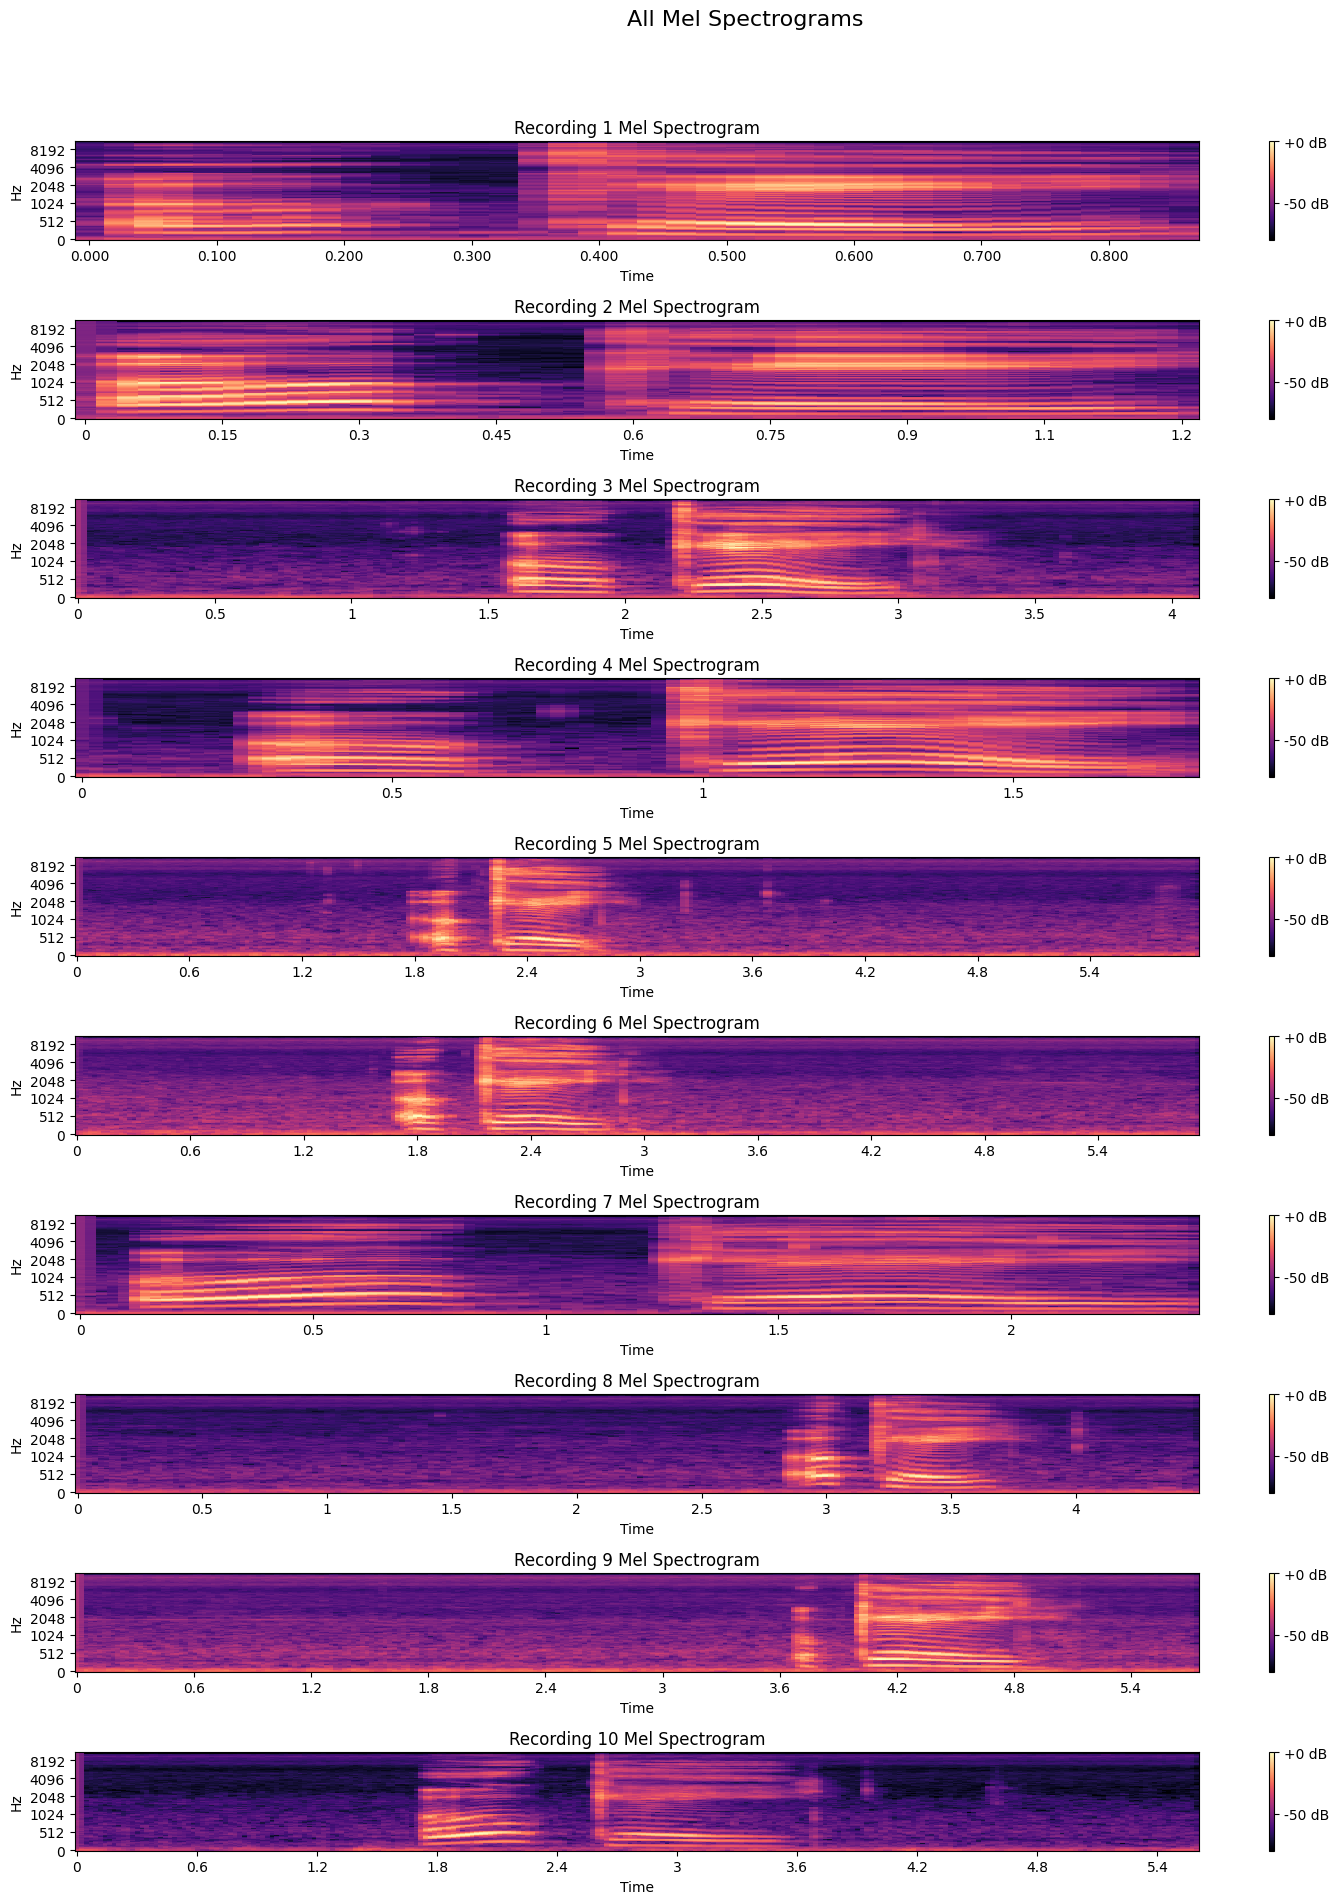

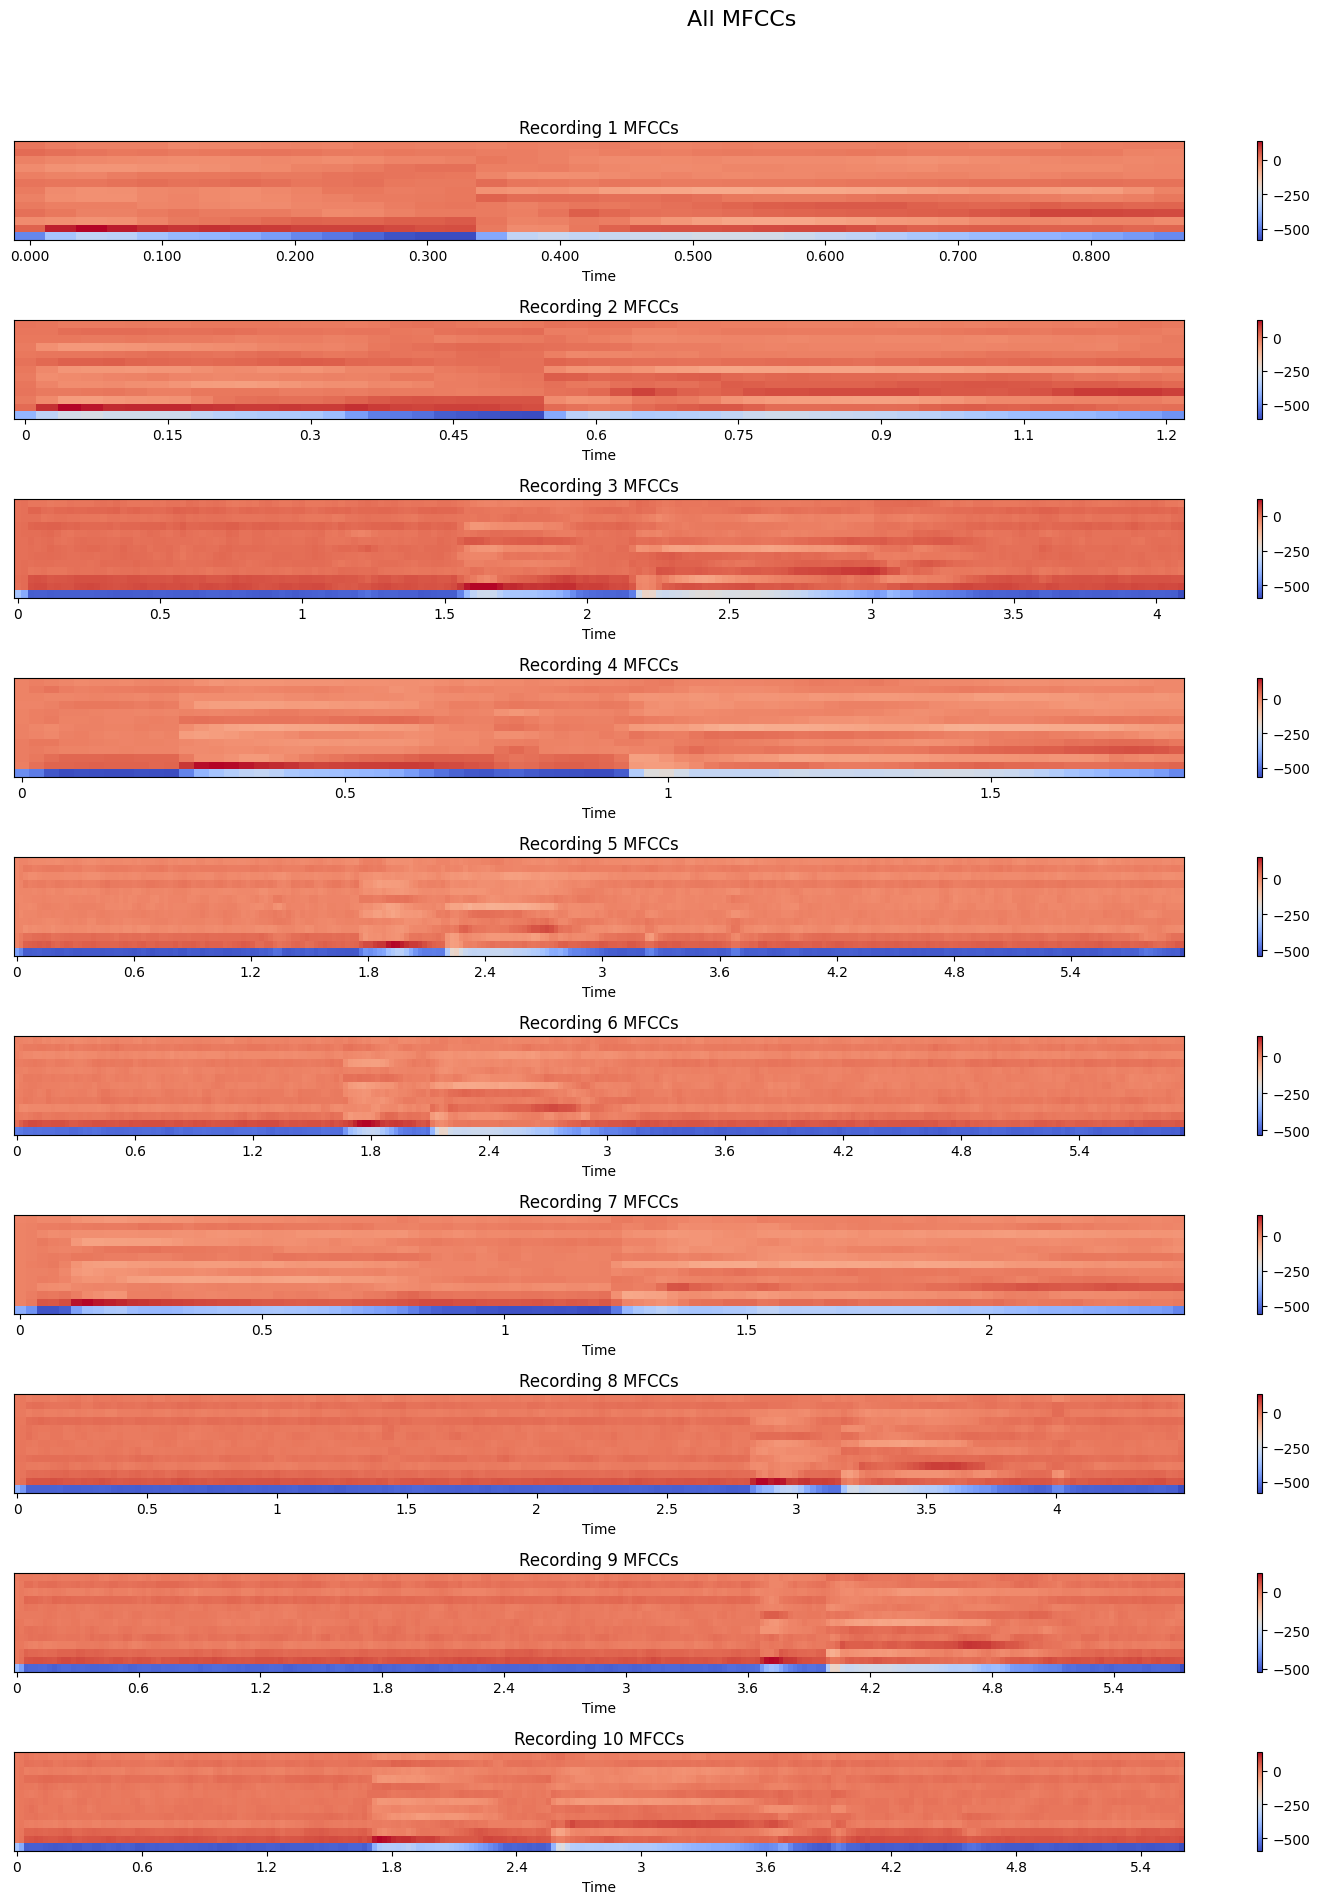


Batch Processing Report:
   Recording ID                  Timestamp  Raw Duration  Processed Duration  \
0             1 2024-11-06 10:39:58.340998           3.0            0.429569   
1             2 2024-11-06 10:40:03.565829           3.0            0.603719   
2             3 2024-11-06 10:40:08.772786           3.0            2.043356   
3             4 2024-11-06 10:40:13.998128           3.0            0.893968   
4             5 2024-11-06 10:40:19.223654           3.0            2.983764   
5             6 2024-11-06 10:40:24.447137           3.0            2.960544   
6             7 2024-11-06 10:40:29.672005           3.0            1.195828   
7             8 2024-11-06 10:40:34.899485           3.0            2.240726   
8             9 2024-11-06 10:40:40.122634           3.0            2.867664   
9            10 2024-11-06 10:40:45.349384           3.0            2.798005   

  MFCC Shape Mel Spec Shape  
0   (13, 38)      (128, 38)  
1   (13, 53)      (128, 53)  
2  

In [34]:
# Run the batch processing
processor = run_batch_processing()

In [35]:
class AudioAnalyzer:
    def __init__(self, processor):
        self.processor = processor
        self.features = processor.features
        
    def analyze_preprocessed_audio(self):
        """Analyze the preprocessed audio samples and generate visualizations"""
        print("Analyzing preprocessed audio samples...")
        
        if not self.features:
            print("No features to analyze")
            return pd.DataFrame()
        
        try:
            # Create figure with multiple subplots
            fig = plt.figure(figsize=(20, 15))
            
            # 1. Amplitude Distribution
            # Shows the distribution of amplitude values for each recording
            plt.subplot(3, 2, 1)
            for i, feat in enumerate(self.features):
                sns.kdeplot(data=feat['processed_audio'], label=f'Recording {i+1}')
            plt.title('Amplitude Distributions of Processed Audio')
            plt.xlabel('Amplitude')
            plt.ylabel('Density')
            plt.legend()
            
            # 2. Energy Comparison
            # Displays the total energy of each recording
            plt.subplot(3, 2, 2)
            energies = [np.sum(feat['processed_audio']**2) for feat in self.features]
            plt.bar(range(1, len(energies) + 1), energies)
            plt.title('Energy per Recording')
            plt.xlabel('Recording Number')
            plt.ylabel('Energy')
            
            # 3. MFCC Comparison
            # Shows the distribution of MFCC coefficients across recordings
            plt.subplot(3, 2, 3)
            mfcc_means = [np.mean(feat['mfccs'], axis=1) for feat in self.features]
            plt.boxplot(mfcc_means)
            plt.title('MFCC Distribution Across Recordings')
            plt.xlabel('MFCC Coefficient')
            plt.ylabel('Value')
            
            # 4. Mel Spectrogram Average
            # Displays the average mel spectrogram across all recordings
            plt.subplot(3, 2, 4)
            try:
                # Find the smallest time dimension
                min_time = min(feat['mel_spec'].shape[1] for feat in self.features)
                
                # Crop all spectrograms to the same length
                mel_specs = [feat['mel_spec'][:, :min_time] for feat in self.features]
                
                # Calculate average
                avg_mel_spec = np.mean(mel_specs, axis=0)
                
                librosa.display.specshow(
                    librosa.power_to_db(avg_mel_spec, ref=np.max),
                    y_axis='mel',
                    x_axis='time'
                )
                plt.colorbar(format='%+2.0f dB')
            except Exception as e:
                print(f"Error plotting mel spectrogram: {str(e)}")
                plt.text(0.5, 0.5, 'Error plotting mel spectrogram', 
                        horizontalalignment='center', verticalalignment='center')
            plt.title('Average Mel Spectrogram Across All Recordings')
            
            # 5. Recording Similarity Matrix
            # Shows correlation between different recordings
            plt.subplot(3, 2, 5)
            try:
                n_recordings = len(self.features)
                similarity_matrix = np.zeros((n_recordings, n_recordings))
                for i in range(n_recordings):
                    for j in range(n_recordings):
                        # Ensure signals have the same length for correlation
                        min_len = min(len(self.features[i]['processed_audio']), 
                                    len(self.features[j]['processed_audio']))
                        similarity_matrix[i,j] = np.corrcoef(
                            self.features[i]['processed_audio'][:min_len],
                            self.features[j]['processed_audio'][:min_len]
                        )[0,1]
                sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
            except Exception as e:
                print(f"Error plotting similarity matrix: {str(e)}")
                plt.text(0.5, 0.5, 'Error plotting similarity matrix', 
                        horizontalalignment='center', verticalalignment='center')
            plt.title('Recording Similarity Matrix')
            
            # 6. Feature Statistics
            # Calculate and display statistical measures for each recording
            stats_data = []
            for i, feat in enumerate(self.features):
                audio = feat['processed_audio']
                stats_data.append({
                    'Recording': i+1,
                    'Mean': np.mean(audio),
                    'Std': np.std(audio),
                    'Max': np.max(audio),
                    'Min': np.min(audio),
                    'Duration': len(audio) / self.processor.fs
                })
            
            stats_df = pd.DataFrame(stats_data)
            plt.subplot(3, 2, 6)
            stats_df[['Mean', 'Std', 'Max', 'Min']].boxplot()
            plt.title('Statistical Distribution of Audio Features')
            
            plt.tight_layout()
            plt.show()
            
            print("\nStatistical Summary of Recordings:")
            print(stats_df.describe())
            
            return stats_df
            
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
            return pd.DataFrame()

    def analyze_mfcc_patterns(self):
        """
        Analyze patterns in MFCC features using PCA
        Reduces high-dimensional MFCC data to 2D for visualization
        """
        try:
            if not self.features:
                print("No features to analyze")
                return
                
            # Prepare MFCC features for PCA
            mfcc_features = np.array([np.mean(feat['mfccs'], axis=1) for feat in self.features])
            
            # Apply PCA dimensionality reduction
            pca = PCA(n_components=2)
            mfcc_2d = pca.fit_transform(mfcc_features)
            
            # Plot results
            plt.figure(figsize=(10, 6))
            plt.scatter(mfcc_2d[:, 0], mfcc_2d[:, 1])
            
            # Add labels to points
            for i, (x, y) in enumerate(mfcc_2d):
                plt.annotate(f'Recording {i+1}', (x, y))
                
            plt.title('PCA of MFCC Features')
            plt.xlabel('First Principal Component')
            plt.ylabel('Second Principal Component')
            plt.grid(True)
            plt.show()
            
            # Display variance explanation
            print("\nExplained variance ratio:", pca.explained_variance_ratio_)
            print("Total variance explained:", sum(pca.explained_variance_ratio_))
            
        except Exception as e:
            print(f"Error in MFCC pattern analysis: {str(e)}")
    
    def run_analysis(self):
        """Run complete audio analysis pipeline"""
        print("Running complete analysis of preprocessed audio...")
        try:
            stats_df = self.analyze_preprocessed_audio()
            self.analyze_mfcc_patterns()
            return stats_df
        except Exception as e:
            print(f"Error running analysis: {str(e)}")
            return pd.DataFrame()

Running complete analysis of preprocessed audio...
Analyzing preprocessed audio samples...


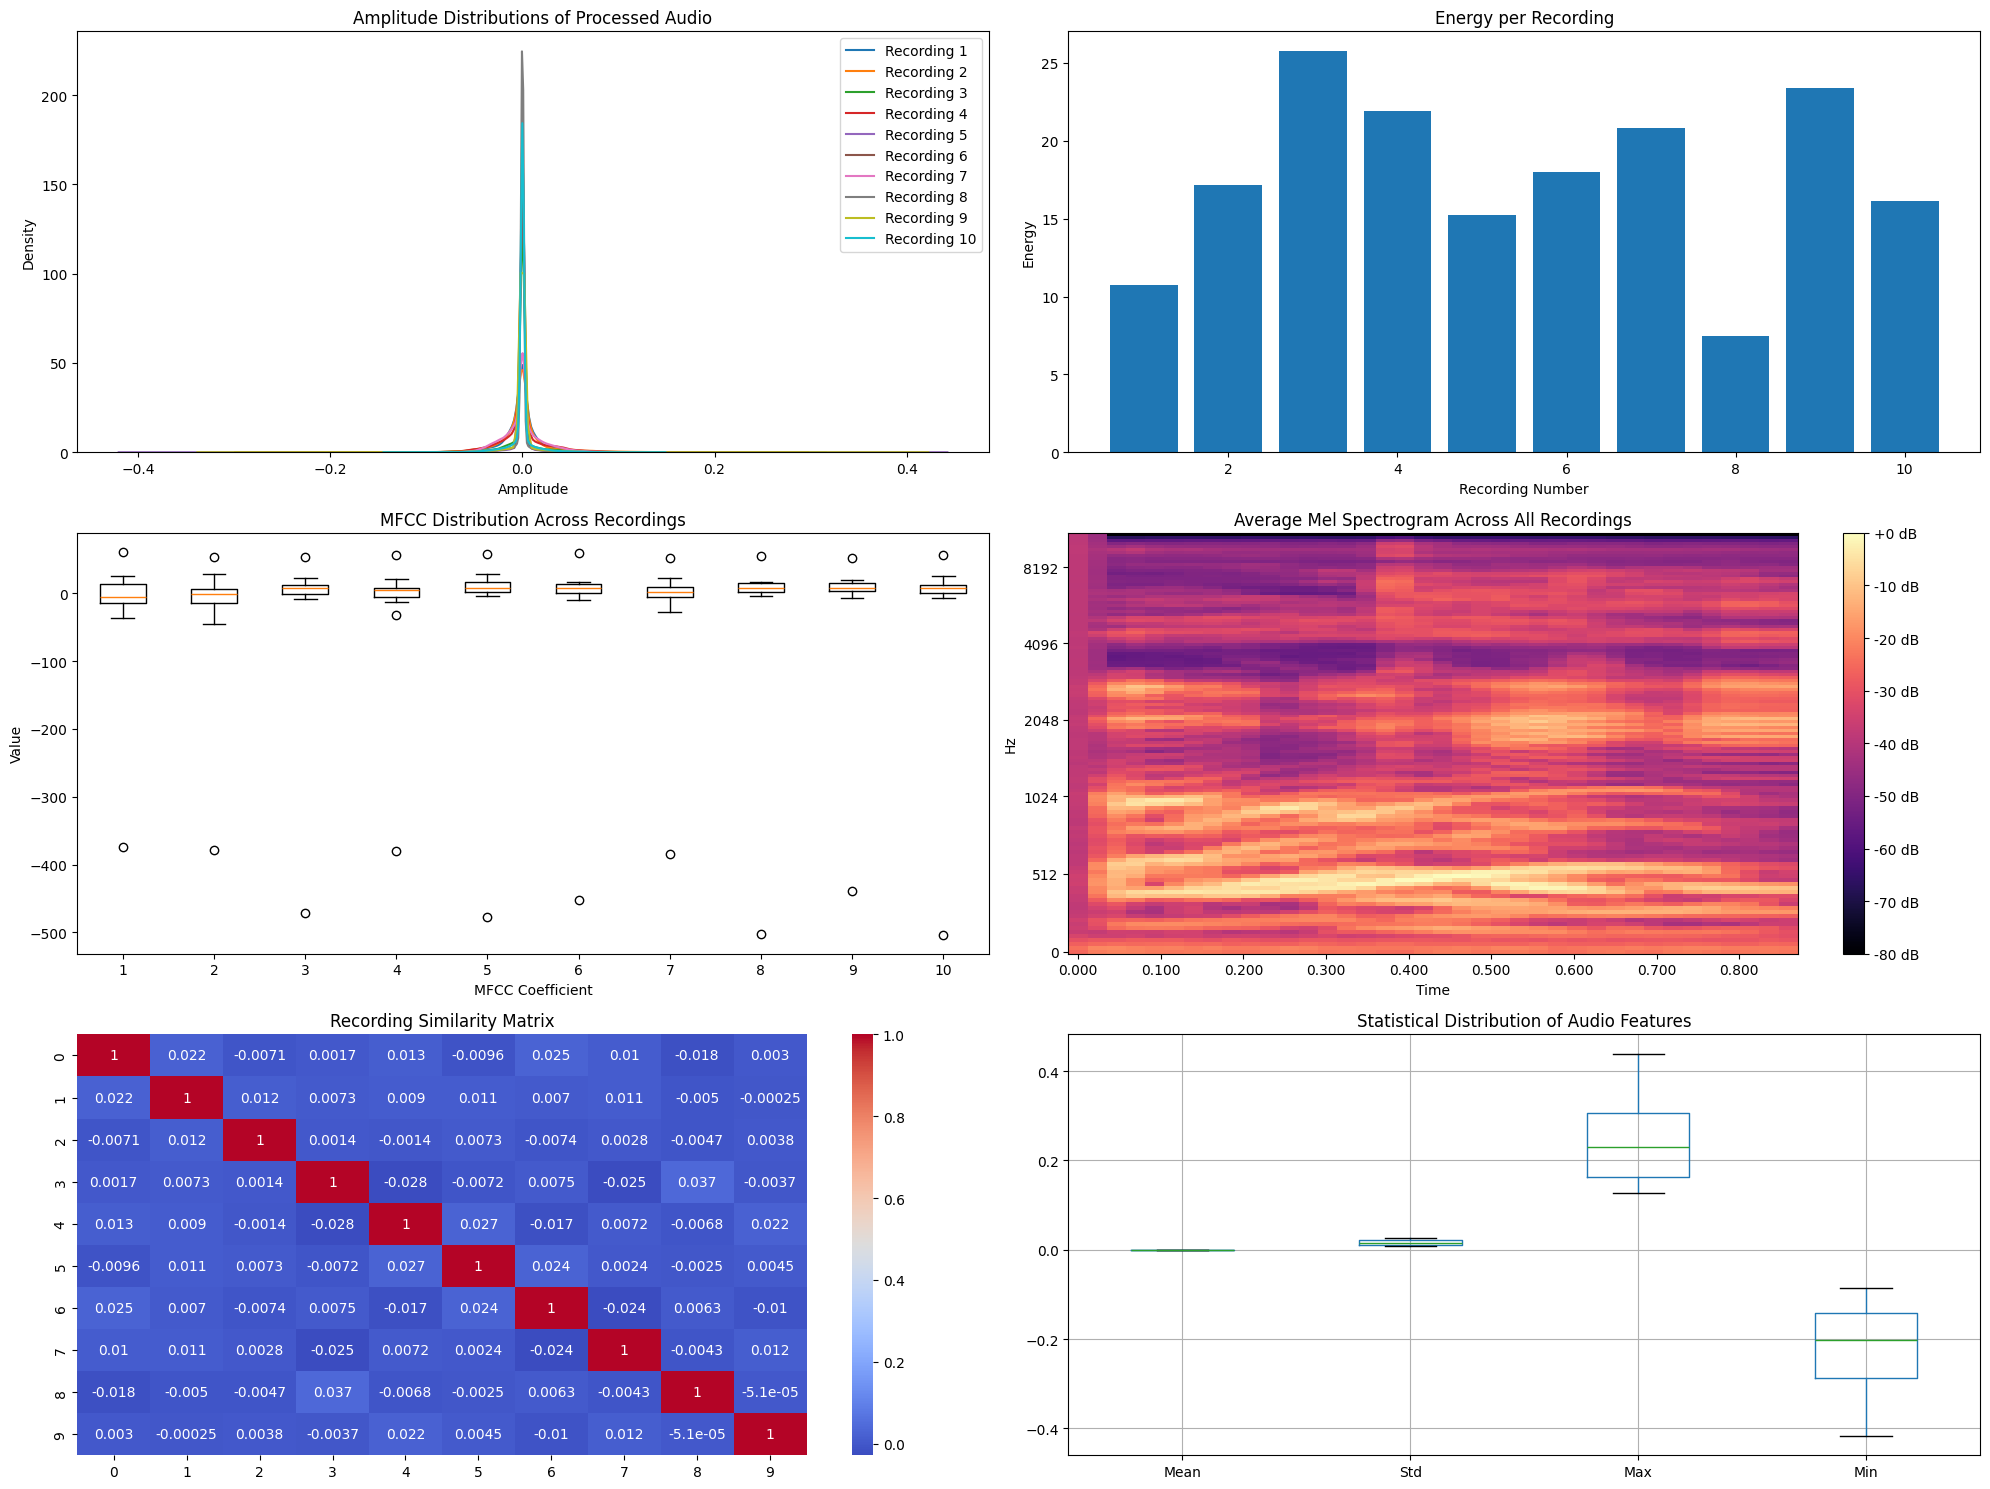


Statistical Summary of Recordings:
       Recording          Mean        Std        Max        Min   Duration
count   10.00000  1.000000e+01  10.000000  10.000000  10.000000  10.000000
mean     5.50000 -1.669904e-07   0.016581   0.255236  -0.218816   1.901714
std      3.02765  2.674672e-06   0.006190   0.110529   0.107472   1.028979
min      1.00000 -4.083118e-06   0.008697   0.127180  -0.417226   0.429569
25%      3.25000 -1.810144e-06   0.011510   0.162637  -0.286441   0.969433
50%      5.50000 -1.135582e-06   0.015250   0.230832  -0.201319   2.142041
75%      7.75000  1.630129e-06   0.022664   0.306551  -0.141140   2.850249
max     10.00000  4.508283e-06   0.025379   0.439395  -0.084850   2.983764


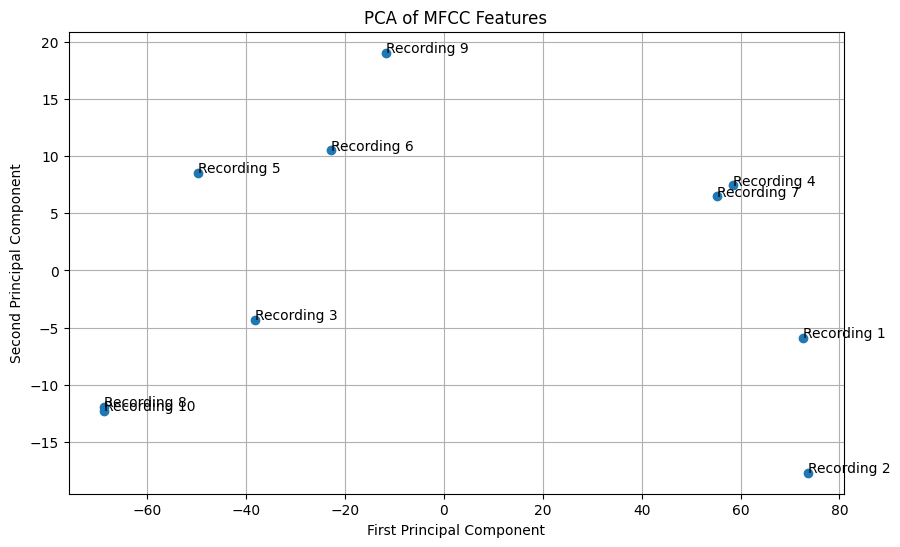


Explained variance ratio: [0.93683976 0.03913306]
Total variance explained: 0.97597283


In [36]:
# Use the analyzer
analyzer = AudioAnalyzer(processor)
stats_df = analyzer.run_analysis()